In [1]:
import sys
sys.path.append('../')
import atlas

import os
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# Custom chemical abundances

In this example, a synthetic spectrum is calculated for a star with the following **non-solar** parameters:

<table width=500>
  <tr><td>Effective temperature, $T_\mathrm{eff}$</td><td>$6000\ \mathrm{K}$</td></tr>
  <tr><td>Surface gravity, $\log(g)$</td><td>$6.0$</td></tr>
  <tr><td>Helium mass fraction, $Y$</td><td>$0.4$</td></tr>
  <tr><td>Metallicity, $[\mathrm{M}/\mathrm{H}]$</td><td>$-1.4$ dex</td></tr>
  <tr><td>Lithium abundance, $[\mathrm{Li}/\mathrm{M}]$</td><td>$-3.0$ dex</td></tr>
  <tr><td>Carbon abundance, $[\mathrm{C}/\mathrm{M}]$</td><td>$-0.65$ dex</td></tr>
  <tr><td>Nitrogen abundance, $[\mathrm{N}/\mathrm{M}]$</td><td>$1.45$ dex</td></tr>
  <tr><td>Alpha enhancement, $[\alpha/\mathrm{M}]$</td><td>$0.6$ dex</td></tr>
</table>

Here alpha elements are oxygen, neon, magnesium, silicon, sulfur, argon, calcium and titanium. All abundances (with the exception of helium mass fraction) are given with respect to the [standard solar values](https://atmos.ucsd.edu/?p=solar).

In `BasicATLAS`, stellar parameters are provided through the `Settings()` class. First, create an instance of this class:

In [2]:
settings = atlas.Settings()

By default, the object will contain solar parameters. For instance, print the currently set effective temperature and surface gravity:

In [3]:
print('Teff: {} K'.format(settings.teff))
print('log(g): {}'.format(settings.logg))

Teff: 5770.0 K
log(g): 4.44


We can also display the assumed standard solar abundances as follows:

In [4]:
print(settings.abun_solar())

OrderedDict([('H', 12.0), ('He', 10.98), ('Li', 3.26), ('Be', 1.38), ('B', 2.79), ('C', 8.5), ('N', 7.86), ('O', 8.76), ('F', 4.56), ('Ne', 8.02), ('Na', 6.24), ('Mg', 7.6), ('Al', 6.45), ('Si', 7.51), ('P', 5.46), ('S', 7.16), ('Cl', 5.5), ('Ar', 6.4), ('K', 5.11), ('Ca', 6.34), ('Sc', 3.15), ('Ti', 4.95), ('V', 3.93), ('Cr', 5.64), ('Mn', 5.43), ('Fe', 7.52), ('Co', 4.99), ('Ni', 6.22), ('Cu', 4.19), ('Zn', 4.56), ('Ga', 3.04), ('Ge', 3.65), ('As', 2.3), ('Se', 3.34), ('Br', 2.54), ('Kr', 3.25), ('Rb', 2.36), ('Sr', 2.87), ('Y', 2.21), ('Zr', 2.62), ('Nb', 1.46), ('Mo', 1.88), ('Tc', -99.99), ('Ru', 1.75), ('Rh', 1.06), ('Pd', 1.65), ('Ag', 1.2), ('Cd', 1.71), ('In', 0.76), ('Sn', 2.04), ('Sb', 1.01), ('Te', 2.18), ('I', 1.55), ('Xe', 2.24), ('Cs', 1.08), ('Ba', 2.18), ('La', 1.1), ('Ce', 1.58), ('Pr', 0.72), ('Nd', 1.42), ('Pm', -99.99), ('Sm', 0.96), ('Eu', 0.52), ('Gd', 1.07), ('Tb', 0.3), ('Dy', 1.1), ('Ho', 0.48), ('Er', 0.92), ('Tm', 0.1), ('Yb', 0.92), ('Lu', 0.1), ('Hf', 0.87

In the output above, all values are expressed as number densities with respect to hydrogen in dex, normalized such that the abundance of hydrogen is 12 dex. To calculate a model for non-solar parameters, the settings object needs to be altered accordingly:

In [5]:
settings.teff = 6000           # Effective temperature in K
settings.logg = 6.0            # Surface gravity as log10(CGS)
settings.Y = 0.4               # Helium mass fraction
settings.zscale = -1.4         # Metallicity, [M/H]

# Enhancements of individual chemical elements with respect to standard solar
# Only specify non-solar values (no need to input zeroes)
settings.abun = {
    'Li': -3.0,
    'C': -0.65,
    'N': 1.45,
    'O': 0.6,
    'Ne': 0.6,
    'Mg': 0.6,
    'Si': 0.6,
    'S': 0.6,
    'Ar': 0.6,
    'Ca': 0.6,
    'Ti': 0.6,
}

<div class="alert alert-block alert-info">
    <b>Note:</b> The default value of the <code>Y</code> attribute of the <code>Settings()</code> object is $-0.1$ which is a special value that is automatically replaced with the standard solar helium abundance. Note however that the solar helium abundance is recorded in <code>BasicATLAS</code> as the number density with respect to hydrogen rather than the helium mass fraction $Y$. As such, the actual value of $Y$ used in models for <code>Y==-0.1</code> will depend on the abundances of metals. On the other hand, the value of $Y$ will remain fixed regardless of metal abundances if it is specified explicitly in the <code>Settings()</code> object by setting <code>Y</code> to anything other than $-0.1$ as in the cell above.
    <br><br>
    At any time, the currently employed mass fractions of hydrogen ($X$), helium ($Y$) and metals ($Z$) can be retrieved from a <code>Settings()</code> object with the <code>mass_fractions()</code> method.
</div>

## Opacity Distribution Functions

`ATLAS-9` demonstrates extremely fast performance due to the virtue of retrieving computationally demanding opacities from pre-tabulated *opacity distribution functions* (ODFs) for all temperatures and pressures at given chemical abundances. For a new set of elemental abundances, a set of ODFs must be calculated first, which may be accomplished with the satellite utility `DFSYNTHE`. The calculation may take considerable time, but fortunately only needs to be ran once for every chemical composition. A set of solar ODFs is already available in `BasicATLAS` out of the box in `data/solar_ODF`, which is employed in `BasicATLAS` by default. In our case, however, a new `DFSYNTHE` calculation is required.

We will store the ODFs in `~/DFSYNTHE_ODF`. Make sure the directory does not already exist and if it does, remove it:

In [6]:
rm -rf ~/DFSYNTHE_ODF

Run `DFSYNTHE` with `atlas.dfsynthe()`:

***The calculation below may take multiple hours***.
ODFs will be tabulated at 57 temperatures from low to high. Low temperature calculations take significantly more time than high temperature counterparts.

In [7]:
run_dir = os.path.expanduser('~/DFSYNTHE_ODF')
atlas.dfsynthe(run_dir, settings)

Will run XNFDF to tabulate atomic and molecular number densities
Launcher created for 57 temperatures from 1995.0 K to 199526.0 K
/home/roman/DFSYNTHE_ODF/xnfpdf.dat
XNFDF halted
Will run DFSYNTHE to tabulate the ODFs (Opacity Distribution Functions)
1995.0 K done! (1/57)
2089.0 K done! (2/57)
2188.0 K done! (3/57)
2291.0 K done! (4/57)
2399.0 K done! (5/57)
2512.0 K done! (6/57)
2630.0 K done! (7/57)
2754.0 K done! (8/57)
2884.0 K done! (9/57)
3020.0 K done! (10/57)
3162.0 K done! (11/57)
3311.0 K done! (12/57)
3467.0 K done! (13/57)
3631.0 K done! (14/57)
3802.0 K done! (15/57)
3981.0 K done! (16/57)
4169.0 K done! (17/57)
4365.0 K done! (18/57)
4571.0 K done! (19/57)
4786.0 K done! (20/57)
5012.0 K done! (21/57)
5370.0 K done! (22/57)
5754.0 K done! (23/57)
6166.0 K done! (24/57)
6607.0 K done! (25/57)
7079.0 K done! (26/57)
7586.0 K done! (27/57)
8128.0 K done! (28/57)
8710.0 K done! (29/57)
9333.0 K done! (30/57)
10000.0 K done! (31/57)
11220.0 K done! (32/57)
12589.0 K done! (33/

`atlas.meta()` can be used to inspect the abundances of a set of ODFs verify that the new set has parameters appropriate for our target model:

In [8]:
atlas.meta(run_dir)

{'abun': OrderedDict([('Li', -3.0),
              ('C', -0.65),
              ('N', 1.45),
              ('O', 0.6),
              ('Ne', 0.6),
              ('Mg', 0.6),
              ('Si', 0.6),
              ('S', 0.6),
              ('Ar', 0.6),
              ('Ca', 0.6),
              ('Ti', 0.6)]),
 'Y': 0.4000050188874604,
 'zscale': -1.400007822415902,
 'type': 'DFSYNTHE'}

Note that `BasicATLAS` will check that the provided set of ODFs is appropriate for target parameters automatically whenever `ATLAS` is run.

## Model

The model can then be calculated as usual except the new set of ODFs is passed to `atlas.atlas()` as an argument. We will carry out the model calculation in `~/ATLAS_LMHA_test`. Make sure the directory does not already exist:

In [9]:
rm -rf ~/ATLAS_LMHA_test

Run `ATLAS` with the new set of ODFs:

In [10]:
model_dir = os.path.expanduser('~/ATLAS_LMHA_test')
atlas.atlas(model_dir, settings, ODF = run_dir)   # ODFs are provided in the "ODF" parameter
                                                  # Note also that we are using the settings object
                                                  # created before

Automatically chosen restart: /home/roman/CoolStar/BasicATLAS/restarts/mm1t6000g6.0.dat
Launcher created
Starting automatic iterations...
15 iterations completed: max[abs(err)] = 0.254 | max[abs(de)] = 2.595
ATLAS-9 halted
ATLAS requested/received validation for /home/roman/ATLAS_LMHA_test successful

Final convergence: max[abs(err)] = 0.254 | max[abs(de)] = 2.595
Saved the model in model.dat
Finished running ATLAS-9 in 0:00:35.389537 s


The function `atlas.meta()` can be used to retrieve the parameters of a calculated model. Let us double check that the newly calculated model has the expected abundances:

In [11]:
atlas.meta(model_dir)

{'abun': OrderedDict([('Li', -3.0),
              ('C', -0.65),
              ('N', 1.45),
              ('O', 0.6),
              ('Ne', 0.6),
              ('Mg', 0.6),
              ('Si', 0.6),
              ('S', 0.6),
              ('Ar', 0.6),
              ('Ca', 0.6),
              ('Ti', 0.6)]),
 'Y': 0.4000050188874604,
 'zscale': -1.400007822415902,
 'teff': 6000.0,
 'logg': 6.0,
 'vturb': 2.0,
 'type': 'ATLAS'}

Finally calculate the synthetic spectrum using `SYNTHE`:

In [12]:
atlas.synthe(model_dir, 100, 3000)

Adapted the ATLAS-9 model to SYNTHE in output_synthe.out
Launcher created for wavelength range (100, 2850), batch 1. Expected number of points: 2009944 (buffer 2010001)
SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_LMHA_test successful
SYNTHE requested/received validation for /home/roman/ATLAS_LMHA_test successful
Launcher created for wavelength range (2850, 3000), batch 2. Expected number of points: 30776 (buffer 2010001)
SYNTHE halted
ATLAS requested/received validation for /home/roman/ATLAS_LMHA_test successful
SYNTHE requested/received validation for /home/roman/ATLAS_LMHA_test successful
Total data points: 2040720
Saved the spectrum in spectrum.dat
Finished running SYNTHE in 0:33:47.428370 s


Plot synthetic spectrum:

Text(0, 0.5, 'Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')

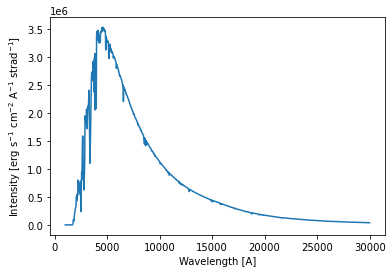

In [13]:
spectrum = atlas.read_spectrum(model_dir, num_bins = 1000)
plt.plot(spectrum['wl'], spectrum['flux'])

plt.xlabel('Wavelength [A]')
plt.ylabel('Intensity [erg s$^{-1}$ cm$^{-2}$ A$^{-1}$ strad$^{-1}$]')